## Import Libraries

In [1]:
import os
import random
import copy
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from kaggle_secrets import UserSecretsClient
import kagglehub
import wandb

## Reproducibility and Data Loading

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [3]:
ai_gen_path    = "/kaggle/input/ai-and-human-art-classification/ai_art_classification/train/AI_GENERATED"
non_ai_gen_path= "/kaggle/input/ai-and-human-art-classification/ai_art_classification/train/NON_AI_GENERATED"

ai_files     = os.listdir(ai_gen_path)    if os.path.isdir(ai_gen_path)    else []
non_ai_files = os.listdir(non_ai_gen_path) if os.path.isdir(non_ai_gen_path) else []

print(f"Found {len(ai_files)} AI images, {len(non_ai_files)} non-AI images")

Found 10330 AI images, 8288 non-AI images


## Helper function

In [33]:
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")
status = wandb.login(key=wandb_api_key)
if (status):
    print('Successfully logged into W&B')
else:
    print('Unable to log into W&B')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged into W&B


## Train/Test split

In [5]:
def split_randomly(files, train_ratio=0.8, seed=42):
    return train_test_split(files, train_size=train_ratio, random_state=seed)

ai_train, ai_test       = split_randomly(ai_files)
non_ai_train, non_ai_test = split_randomly(non_ai_files)

## Training & Evaluation loops

In [6]:
def train_one_epoch(epoch, model, train_loader, criterion, optimizer, device,log_step=128):
    model.train()
    running_loss = 0.0
    running_loop = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and accuracy stats 
        running_loss += loss.item()
        running_loop += 1
        train_loss = running_loss / running_loop
        
        if i % log_step == log_step - 1 or i == len(train_loader) - 1:                
            print(f'[Epoch {epoch + 1:2d}, iter {i + 1:5d}] train_loss: {train_loss:.3f}')
            running_loss = 0.0
            running_loop = 0.0
    
    return train_loss

In [7]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Calculate predictions
            preds = (outputs > 0.5).float()
            
            # Accumulate statistics
            
            test_loss += loss.item() 
            total += labels.size(0)
            correct += torch.sum(preds == labels).item()
    
    # Calculate test loss and accuracy
    test_loss = test_loss / total
    test_acc = 100 * correct / total
    
    return test_loss, test_acc

In [8]:
def train(model, optimizer, criterion, train_loader, test_loader, config, device):
    # Track best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Print training header
    print("\n" + "#"*50)
    print(f"Start training for {config['num_epochs']} epochs")
    print("#"*50)
    
    # Training loop
    for epoch in range(config['num_epochs']):
       
        train_loss = train_one_epoch(
            epoch, 
            model, 
            train_loader, 
            criterion, 
            optimizer, 
            device
        )
        
        # Evaluate on test set 
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        print(f"--> Epoch {epoch+1} completed. Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.2f}%\n")
        wandb.log({"Train Loss": train_loss, "Test Loss": test_loss, "Test Accuracy": test_acc})
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f" New best model saved! (Test Acc: {test_acc:.2f}%)\n")
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f'\nTraining complete! Best test accuracy: {best_acc:.2f}%')

    return model

## Datasets and preprocessings

In [9]:
class AIDetectionDataset(Dataset):
    def __init__(self, ai_files, non_ai_files, ai_dir, non_ai_dir, transform=None):
        self.file_paths = [os.path.join(ai_dir, fn) for fn in ai_files] + \
                          [os.path.join(non_ai_dir, fn) for fn in non_ai_files]
        self.labels     = [1]*len(ai_files) + [0]*len(non_ai_files)
        self.transform  = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor([self.labels[idx]], dtype=torch.float32)

In [10]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = AIDetectionDataset(ai_train, non_ai_train, ai_gen_path, non_ai_gen_path, transform=train_transform)
test_ds  = AIDetectionDataset(ai_test,  non_ai_test,  ai_gen_path, non_ai_gen_path, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")

Train size: 14894, Test size: 3724


## Model Training

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
def build_model(config, device):
    weights = (EfficientNet_B0_Weights.IMAGENET1K_V1
               if config['weights']=="IMAGENET1K_V1" else None)
    model = efficientnet_b0(weights=weights).to(device)

    if config['finetuned_layers'] == 'output':
        for p in model.parameters():
            p.requires_grad = False

    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1280, out_features=256),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(in_features=256, out_features=1),
        nn.Sigmoid()
    ).to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    if config['optimizer'] == "Adam":
        opt = optim.Adam(params, lr=config['lr'])
    else:
        opt = optim.SGD(params, lr=config['lr'], momentum=config['momentum'])
    
    return model, opt

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


config = {
    'weights': "none",    
    'finetuned_layers': "all",     
    'lr': 0.1,
    'momentum': 0.9,
    'num_epochs': 10,
    'optimizer': "Adam"           
}

# 1) Build the model
model, optimizer = build_model(config, device)

# 2) Print its architecture
print(model)

Using device: cuda
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2)

## Clear Cache


In [165]:
import torch, gc

# Delete any lingering model / optimizer objects
for name in list(globals()):
    if name.startswith("model") or name.startswith("optimizer"):
        del globals()[name]

# Force Python GC and PyTorch to release everything
gc.collect()
torch.cuda.empty_cache()


## Model1: ADAM(ALL Layers)

In [14]:
# Loss function 
criterion = nn.BCELoss()

In [15]:
config = {
        'weights': "IMAGENET1K_V1",    # or None
        'finetuned_layers': "all",     # "output" to freeze backbone
        'lr': 0.001,
        'momentum': 0.9,
        'num_epochs': 10,
        'optimizer': "Adam"            # "SGD" or "Adam"
    }

In [16]:
wandb.init(
    project='EfficientNetB0-AI_Image_Detection',
    name='ALL(ADAM)',
    config = {
        'weights'         : config['weights'],
        'finetuned_layers': config['finetuned_layers'],
        'lr'              : config['lr'],
        'momentum'        : config['momentum'],
        'num_epochs'      : config['num_epochs'],
        'optimizer': config['optimizer']
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [17]:
model1, optimizer = build_model(config, device)
model1 = model1.to(device)

# Train the model
model1 = train(model1, optimizer, criterion, train_loader, test_loader, config, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 181MB/s]



##################################################
Start training for 10 epochs
##################################################
[Epoch  1, iter   128] train_loss: 0.310
[Epoch  1, iter   256] train_loss: 0.237
[Epoch  1, iter   384] train_loss: 0.216
[Epoch  1, iter   466] train_loss: 0.185
--> Epoch 1 completed. Train Loss: 0.185, Test Loss: 0.005, Test Accuracy: 94.17%

 New best model saved! (Test Acc: 94.17%)

[Epoch  2, iter   128] train_loss: 0.192
[Epoch  2, iter   256] train_loss: 0.185
[Epoch  2, iter   384] train_loss: 0.166
[Epoch  2, iter   466] train_loss: 0.166
--> Epoch 2 completed. Train Loss: 0.166, Test Loss: 0.005, Test Accuracy: 94.25%

 New best model saved! (Test Acc: 94.25%)

[Epoch  3, iter   128] train_loss: 0.157
[Epoch  3, iter   256] train_loss: 0.161
[Epoch  3, iter   384] train_loss: 0.153
[Epoch  3, iter   466] train_loss: 0.137
--> Epoch 3 completed. Train Loss: 0.137, Test Loss: 0.004, Test Accuracy: 95.49%

 New best model saved! (Test Acc: 95.49%)

In [18]:
wandb.finish()

Test Accuracy,▁▁▅▄▅▆▅██▇
Test Loss,█▇▅▅▃▂▄▃▃▁
Train Loss,█▇▅▅▅▃▃▂▁▃
Test Accuracy,96.05263
Test Loss,0.00319
Train Loss,0.11095


## Model2: SGD (ALL layers)

In [29]:
config =  {
    'weights'         : "IMAGENET1K_V1",
    'finetuned_layers': "all",
    'lr'              : 0.001,
    'momentum'        : 0.9,
    'num_epochs'      : 10,
    'optimizer': "SGD"
}

In [39]:
wandb.init(
    project='EfficientNetB0-AI_Image_Detection',
    name='ALL(SGD)',
    config = {
        'weights'         : config['weights'],
        'finetuned_layers': config['finetuned_layers'],
        'lr'              : config['lr'],
        'momentum'        : config['momentum'],
        'num_epochs'      : config['num_epochs'],
        'optimizer': config['optimizer']
    }
)

In [40]:
model2, optimizer = build_model(config, device)
model2 = model2.to(device)

# Train the model
model2 = train(
    model2,
    optimizer,
    criterion,
    train_loader,
    test_loader,
    config,
    device
)


##################################################
Start training for 10 epochs
##################################################
[Epoch  1, iter   128] train_loss: 0.638
[Epoch  1, iter   256] train_loss: 0.490
[Epoch  1, iter   384] train_loss: 0.379
[Epoch  1, iter   466] train_loss: 0.325
--> Epoch 1 completed. Train Loss: 0.325, Test Loss: 0.009, Test Accuracy: 91.11%

 New best model saved! (Test Acc: 91.11%)

[Epoch  2, iter   128] train_loss: 0.282
[Epoch  2, iter   256] train_loss: 0.257
[Epoch  2, iter   384] train_loss: 0.230
[Epoch  2, iter   466] train_loss: 0.212
--> Epoch 2 completed. Train Loss: 0.212, Test Loss: 0.006, Test Accuracy: 92.64%

 New best model saved! (Test Acc: 92.64%)

[Epoch  3, iter   128] train_loss: 0.212
[Epoch  3, iter   256] train_loss: 0.200
[Epoch  3, iter   384] train_loss: 0.191
[Epoch  3, iter   466] train_loss: 0.188
--> Epoch 3 completed. Train Loss: 0.188, Test Loss: 0.005, Test Accuracy: 93.61%

 New best model saved! (Test Acc: 93.61%)

In [42]:
wandb.finish()

## Evaluation

In [44]:
def evaluate_model(model, data_loader, device):
    """
    Evaluate model performance with confusion matrix and classification report
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        # Remove tqdm to avoid any import-related issues
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)
            
            # Forward pass
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            
            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to arrays for sklearn functions
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate classification report
    report = classification_report(all_labels, all_preds, 
                                  target_names=["Non-AI Generated", "AI Generated"])
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    
    return cm, report, fpr, tpr, roc_auc

In [45]:
def plot_confusion_matrix(cm, classes=["Non-AI", "AI"], title="Confusion Matrix", save_path=None):
    """
    Plot a single confusion matrix and optionally save it
    """
    plt.figure(figsize=(7, 5))
    im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    
    # Add axis labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()  # Display each matrix separately

In [46]:
def evaluate_all_models(models, test_loader, device, model_names):
    """
    Evaluate all models and plot individual confusion matrices
    """
    results = []
    
    for i, (model, name) in enumerate(zip(models, model_names)):
        print(f"\nEvaluating {name}...")
        cm, report, fpr, tpr, roc_auc = evaluate_model(model, test_loader, device)
        
        # Create filename-safe version of model name
        safe_name = name.replace(" ", "_").replace(":", "")
        
        # Plot and save individual confusion matrix
        save_path = f"{safe_name}_confusion_matrix.png"
        plot_confusion_matrix(cm, title=f"{name} Confusion Matrix", save_path=save_path)
        
        # Store results
        results.append({
            'name': name,
            'cm': cm,
            'report': report,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })
        
        # Print classification report
        print(f"\n{name} Classification Report:")
        print(report)
    
    # Plot and save ROC curves for all models
    plt.figure(figsize=(10, 8))
    for result in results:
        plt.plot(result['fpr'], result['tpr'], label=f"{result['name']} (AUC = {result['roc_auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig("roc_curves_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot and save accuracy comparison
    accuracies = []
    for result in results:
        # Extract accuracy from classification report
        report_lines = result['report'].split('\n')
        accuracy_line = [line for line in report_lines if "accuracy" in line][0]
        accuracy = float(accuracy_line.split()[-1])
        accuracies.append(accuracy)
    
    # Plot accuracies    
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies)
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("model_accuracy_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return results


Evaluating Model 1: All Layers (Adam)...


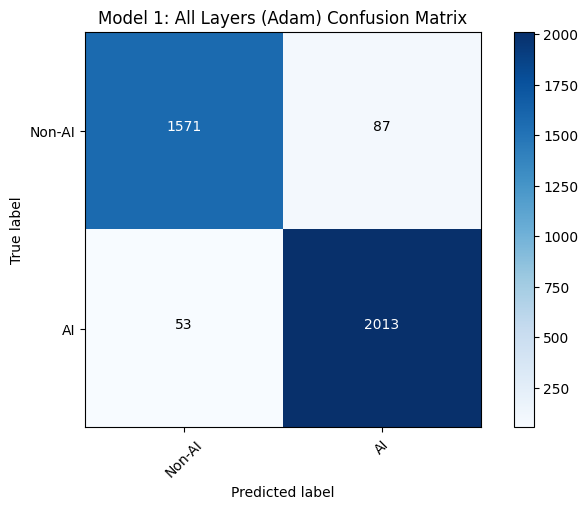


Model 1: All Layers (Adam) Classification Report:
                  precision    recall  f1-score   support

Non-AI Generated       0.97      0.95      0.96      1658
    AI Generated       0.96      0.97      0.97      2066

        accuracy                           0.96      3724
       macro avg       0.96      0.96      0.96      3724
    weighted avg       0.96      0.96      0.96      3724


Evaluating Model 2: All Layers (SGD)...


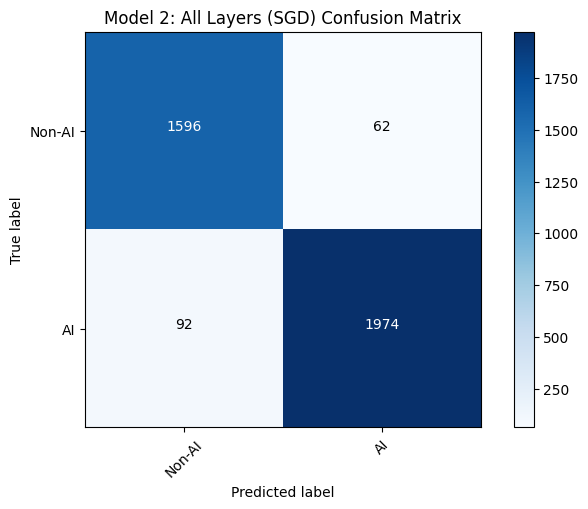


Model 2: All Layers (SGD) Classification Report:
                  precision    recall  f1-score   support

Non-AI Generated       0.95      0.96      0.95      1658
    AI Generated       0.97      0.96      0.96      2066

        accuracy                           0.96      3724
       macro avg       0.96      0.96      0.96      3724
    weighted avg       0.96      0.96      0.96      3724



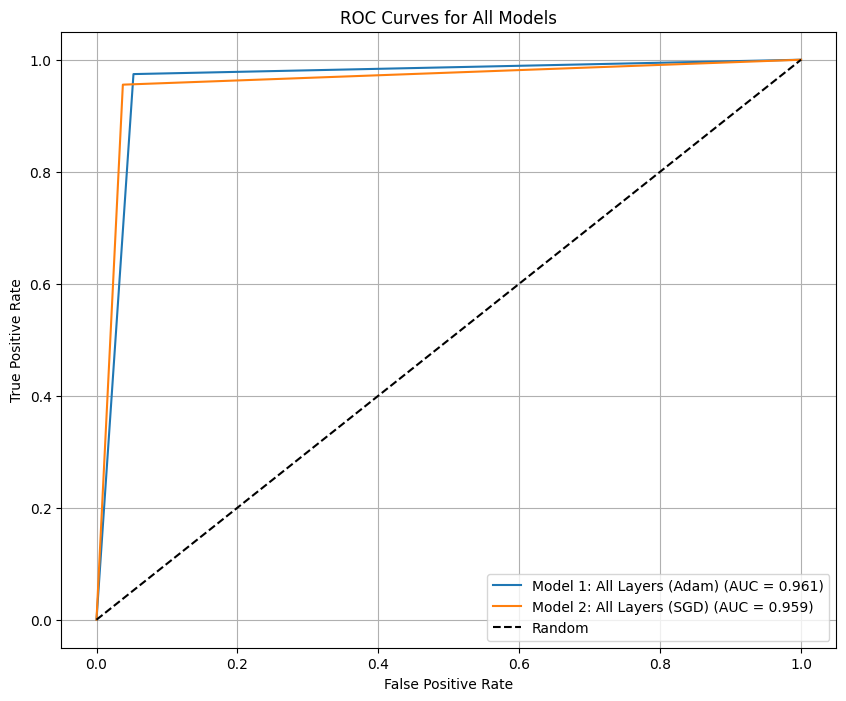

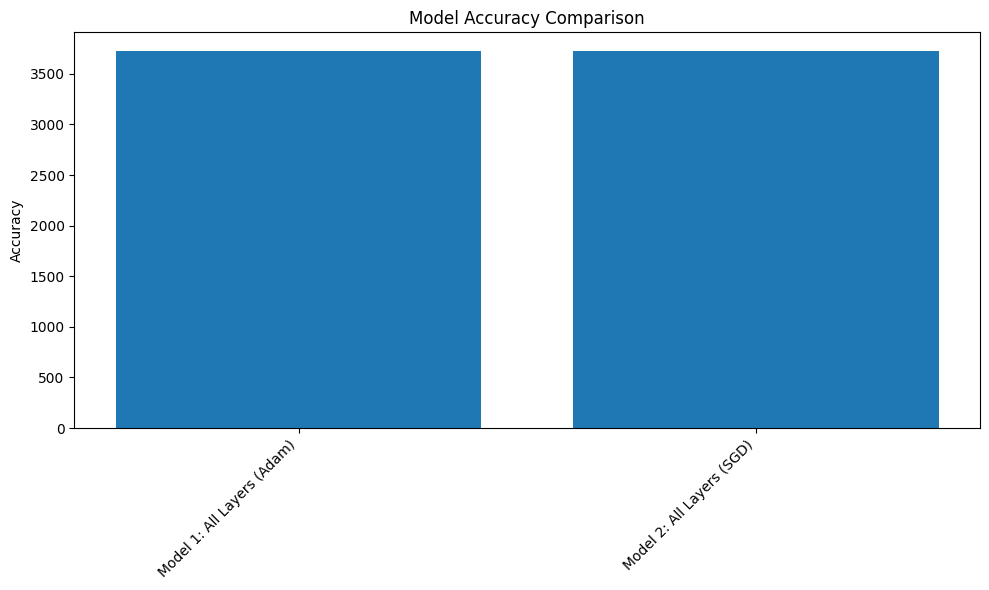

In [48]:
# Evaluate all models
model_list = [model1, model2]
model_names = [
    "Model 1: All Layers (Adam)",
    "Model 2: All Layers (SGD)",
]

# Run evaluation
evaluation_results = evaluate_all_models(model_list, test_loader, device, model_names)

## Save model

In [50]:
# Save the best model
best_model = model1
best_model_path = f"effbest_model_ai_detection.pth"
torch.save(model1.state_dict(), best_model_path)
print(f"Best model saved to {best_model_path}")

Best model saved to effbest_model_ai_detection.pth
